In [16]:
# This notebook fits an initial model at alpha0
# then it refits alternative models for different alpha's

In [17]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

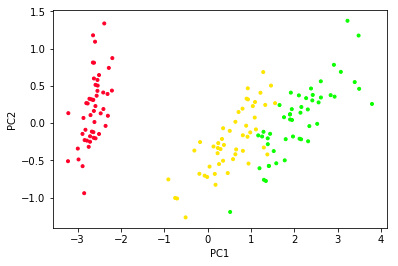

In [4]:
# load (or simulate) data
simulate = False
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    
    # run PCA
    pca_fit = PCA()
    pca_fit.fit(features)
    pc_features = pca_fit.transform(features)
    
    # plot
    fig1 = plt.figure(1)
    fig = fig1.add_subplot(111)
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')
    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')

# Set up the model

In [5]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(3.5)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [6]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [7]:
# run k-means init
n_kmeans_init = 50
init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [8]:
t0 = time.time()
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(init_global_free_param)
t_newton = time.time() - t0

assert converged
print('Done. Converged: ', converged)

Iter: 0	 RMSE: 5.561691210660702	 Objective: 10870.81219254104
Iter: 50	 RMSE: 26.022491793847735	 Objective: 191.7290169868345
Iter: 100	 RMSE: 12.286143139502276	 Objective: -276.0660272405754
Iter: 150	 RMSE: 11.227178010565243	 Objective: -296.81035592144536
Iter: 200	 RMSE: 11.244825282589344	 Objective: -302.6339992040039
Iter: 250	 RMSE: 11.201855521561946	 Objective: -303.9962560949981
Iter: 300	 RMSE: 11.19347114499125	 Objective: -304.5516832992632
Iter: 350	 RMSE: 11.205506432728294	 Objective: -304.94682221593894
Iter: 400	 RMSE: 11.210963998262477	 Objective: -305.3721130815602
Iter: 450	 RMSE: 11.215515067234827	 Objective: -305.5063152032766
Iter: 500	 RMSE: 11.213104218491223	 Objective: -305.51375242774554
         Current function value: -305.514051
         Iterations: 500
         Function evaluations: 523
         Gradient evaluations: 523
Iter: 523	 RMSE: 11.213220678852293	 Objective: -305.5140514650583
Iter: 524	 RMSE: 11.213345096507107	 Objective: -305.5141182

In [9]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [10]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [11]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

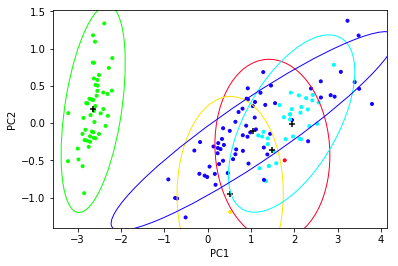

In [12]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [13]:
# save model

fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(base_alpha, dataset_name)
json_output_file = os.path.join(
    './iris_fits_for_nips/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json


# Fit multiple models and save them: 

In [21]:
# we use the original model as an initialization and refit for a range of alphas

In [14]:
alpha_vec = np.arange(1, 14) * 0.5
# alpha_vec = np.array([1.0])
print(alpha_vec)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5]


In [15]:

for i in range(len(alpha_vec)): 
       
    # define prior
    prior_params = gmm_utils.get_default_prior_params(dim)
    prior_params['alpha'].set(alpha_vec[i])

    prior_params['prior_gamma_df'].set(8)
    prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

    # define model 
    k_approx = 12
    gh_deg = 8
    model_refit = gmm_utils.DPGaussianMixture(
        features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

    # initialize from the original model 
    init_global_free_param = deepcopy(best_param)
    # fit model
    t0 = time.time()
    best_param_refit, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        model_refit.optimize_full(init_global_free_param)
    t_newton = time.time() - t0

    assert converged
    print('Done. Converged: ', converged)

    # get KL
    kl_hessian = model_refit.objective.fun_free_hessian(best_param_refit)

    # save model
    fit_dict = gmm_utils.get_checkpoint_dictionary(model_refit, kl_hessian, seed=453453)
    alpha = model_refit.prior_params['alpha'].get()
    filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(alpha, dataset_name)
    json_output_file = os.path.join(
        './iris_fits_for_nips/',
        filename)
    print('saving fit dict to ', json_output_file)
    with open(json_output_file, 'w') as outfile:
        json.dump(fit_dict, outfile)


321.4709673641978
Iter: 0	 RMSE: 11.213295585134356	 Objective: -308.3613750630773
Iter: 50	 RMSE: 11.165363876549174	 Objective: -308.45760819326955
Optimization terminated successfully.
         Current function value: -308.457687
         Iterations: 68
         Function evaluations: 84
         Gradient evaluations: 84
Iter: 84	 RMSE: 11.165205063682857	 Objective: -308.45768717775735
Iter: 85	 RMSE: 11.16520514847055	 Objective: -308.4576871778969
Optimization terminated successfully.
         Current function value: -308.457687
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha0.5_iris.json
321.4709673641978
Iter: 0	 RMSE: 11.213295585134356	 Objective: -307.8868323266869
Iter: 50	 RMSE: 11.17123318845411	 Objective: -307.95318538949755
Optimization terminated successfully.
         Current function value: -307.953256
      